# Your first convolutional neural network

# imports

In [1]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 

from keras.datasets import cifar10

# W&B Integration
import sys
sys.path.insert(0, '../..')
from utils.wandb_utils import init_wandb, get_metrics_logger
import wandb

from utils.callbacks import LRFinder, get_lr_scheduler

2025-12-28 06:19:28.911223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Global settings
BATCH_SIZE = 1024
EPOCHS = 10
OPTIMIZER_NAME = 'adam'
DATASET_NAME = 'cifar10'
MODEL_TYPE = 'cnn'
LAYERS_DESC = '4_conv_2_dense'

# Initialize W&B run
run = init_wandb(
    name="02_03_cnn",
    project="generative-deep-learning",
    config={
        "model": MODEL_TYPE,
        "dataset": DATASET_NAME,
        "layers": LAYERS_DESC,
        "learning_rate": "auto", # Will be updated after LRFinder
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": OPTIMIZER_NAME,
    }
)

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# data

In [4]:
NUM_CLASSES = 10

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [7]:
x_train[54, 12, 13, 1] 

np.float32(0.36862746)

# architecture

In [8]:
input_layer = Input(shape=(32,32,3))

conv_layer_1 = Conv2D(
    filters = 10
    , kernel_size = (4,4)
    , strides = 2
    , padding = 'same'
    )(input_layer)

conv_layer_2 = Conv2D(
    filters = 20
    , kernel_size = (3,3)
    , strides = 2
    , padding = 'same'
    )(conv_layer_1)

flatten_layer = Flatten()(conv_layer_2)

output_layer = Dense(units=10, activation = 'softmax')(flatten_layer)

model = Model(input_layer, output_layer)

I0000 00:00:1766902796.107166   23660 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 10)     │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,120 (59.06 KB)

 Trainable params: 15,120 (59.06 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
input_layer = Input((32,32,3))

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

2025-12-28 06:20:12.518195: I external/local_xla/xla/service/service.cc:163] XLA service 0x78a9ec09c1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-28 06:20:12.518262: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-12-28 06:20:12.764922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-28 06:20:13.679605: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-28 06:20:14.779097: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1024,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

Optimal Learning Rate: 0.00028183829272165895


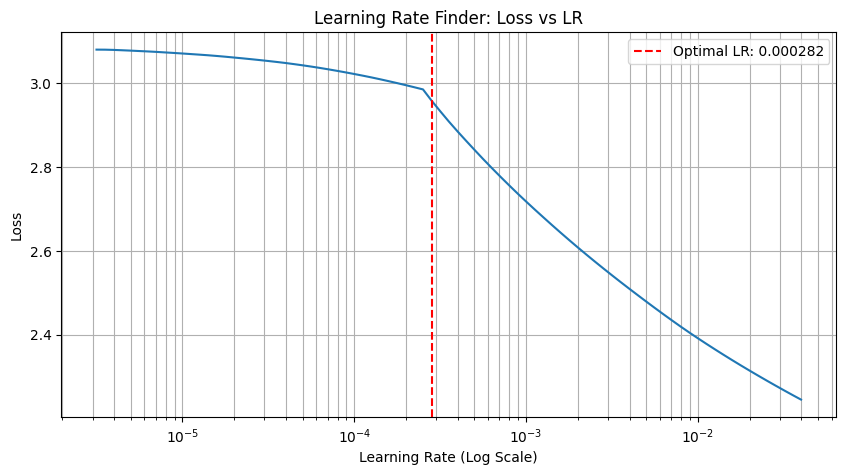

Suggested optimal learning rate: 0.000282
Updated W&B config with optimal learning rate.


In [12]:
# Learning Rate Finder Analysis
# This cell finds the optimal initial learning rate by running a test for a few epochs.
# Look for the steepest drop in the generated plot. 
# Note: This uses a cloned model to avoid affecting the weights of the main model below.


# Clone model to ensure fresh weights
lr_model = tf.keras.models.clone_model(model)

# Compile with a small starting LR
lr_opt = Adam(learning_rate=1e-6)
lr_model.compile(loss='categorical_crossentropy', optimizer=lr_opt, metrics=['accuracy'])

# Instantiate LRFinder
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-1, steps=100)

# Run training for a short duration (e.g. 100 steps)
# With Batch Size 1024 and 50k images, 1 epoch is ~48 steps. So we run ~2 epochs.
history = lr_model.fit(x_train, y_train,
                       batch_size=BATCH_SIZE,
                       steps_per_epoch=50,
                       epochs=2,
                       callbacks=[lr_finder],
                       verbose=0) # Architecture summary above hidden to reduce noise

# Plot Loss vs Learning Rate using the new helper method
lr_finder.plot_loss()

# Get the optimal learning rate automatically
optimal_lr = lr_finder.get_optimal_lr()
print(f'Suggested optimal learning rate: {optimal_lr:.6f}')

# Update W&B config with the found learning rate
wandb.config.update({"learning_rate": optimal_lr})
print("Updated W&B config with optimal learning rate.")

# train

In [13]:
# Use the optimal learning rate from LRFinder
opt = Adam(learning_rate=optimal_lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(f'Using optimal learning rate: {optimal_lr:.6f}')

Using optimal learning rate: 0.000282


In [14]:
model.fit(x_train
          , y_train
          , batch_size=BATCH_SIZE
          , epochs=EPOCHS
          , shuffle=True
          , validation_data = (x_test, y_test)
          , callbacks=[get_metrics_logger(), get_lr_scheduler()]
          )

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2791 - loss: 2.2463

2025-12-28 06:21:19.505643: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[784,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[784,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-28 06:21:20.026115: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[784,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[784,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.3428 - loss: 1.9836 - val_accuracy: 0.1539 - val_loss: 2.3236 - learning_rate: 2.8184e-04
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4494 - loss: 1.5658 - val_accuracy: 0.1484 - val_loss: 2.6010 - learning_rate: 2.8184e-04
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4927 - loss: 1.4291
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00014091914636082947.
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5037 - loss: 1.4028 - val_accuracy: 0.1158 - val_loss: 2.8291 - learning_rate: 2.8184e-04
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5397 - loss: 1.3007 - val_accuracy: 0.1225 - val_loss: 2.9158 - learning_rate: 1.4092e-04
Epoch 5/10
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5594 - loss: 1.2470
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.045957318041474e-05.
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5588 - loss: 1.2502 - v

In [15]:
model.layers

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <LeakyReLU name=leaky_re_lu, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <LeakyReLU name=leaky_re_lu_1, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <LeakyReLU name=leaky_re_lu_2, built=True>,
 <Conv2D name=conv2d_5, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <LeakyReLU name=leaky_re_lu_3, built=True>,
 <Flatten name=flatten_1, built=True>,
 <Dense name=dense_1, built=True>,
 <BatchNormalization name=batch_normalization_4, built=True>,
 <LeakyReLU name=leaky_re_lu_4, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_2, built=True>,
 <Activation name=activation, built=True>]

In [16]:
model.layers[4].get_weights()

[array([[[[ 0.09849101, -0.08814474, -0.05137669, ...,  0.00676485,
            0.07986886, -0.06635119],
          [-0.05675767,  0.02318354, -0.02821879, ...,  0.04510478,
            0.05007006, -0.01863586],
          [ 0.07209392, -0.00587882, -0.04103066, ..., -0.03584968,
            0.03683892, -0.06130455],
          ...,
          [ 0.09526367, -0.0681958 , -0.07174274, ..., -0.00477956,
           -0.06491601,  0.051962  ],
          [-0.05075111, -0.06360638, -0.07473312, ..., -0.00880909,
           -0.06911147, -0.09249803],
          [-0.03689776, -0.00569812,  0.11102448, ..., -0.0581601 ,
            0.03294826,  0.05673413]],
 
         [[-0.06761295,  0.03781413,  0.02498345, ..., -0.01420258,
            0.06800976, -0.01679673],
          [-0.02764937, -0.04826974,  0.0237937 , ...,  0.04073314,
           -0.01248132,  0.08545991],
          [ 0.02897538, -0.09118716,  0.02432008, ...,  0.00195357,
           -0.01200679,  0.10343573],
          ...,
          [ 0

# analysis

In [17]:
model.evaluate(x_test, y_test, batch_size=1000)

2025-12-28 06:21:53.064889: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1000,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1000,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-28 06:21:53.740334: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1000,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[1000,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4652 - loss: 1.4920


[1.4919764995574951, 0.4652000069618225]

In [18]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

2025-12-28 06:21:58.110326: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-28 06:21:58.230999: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

305/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2025-12-28 06:22:01.635618: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-28 06:22:01.747611: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


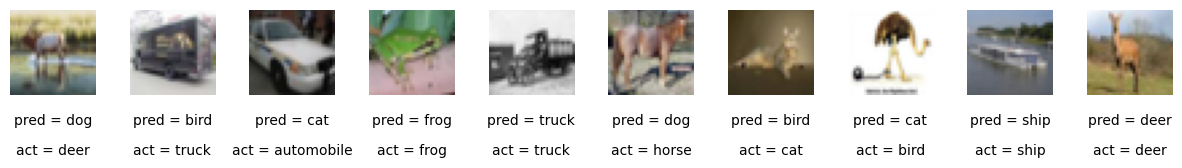

In [19]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)


In [20]:
# Finish W&B run
wandb.finish()

epoch/accuracy,▁▄▅▆▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,███▄▄▂▂▁▁▁
epoch/loss,█▅▃▂▂▂▁▁▁▁
epoch/val_accuracy,▂▂▁▁▁▂▃▄▆█
epoch/val_loss,▅▆███▇▆▄▂▁
epoch/accuracy,0.59824
epoch/epoch,9
epoch/learning_rate,4e-05
epoch/loss,1.1391
epoch/val_accuracy,0.4652
